# Final Project

*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 4 students.*

* Fan Chen
* Clarissa Ding


---

## Sparse Interactions

### Preparation (3pts)

Review the paper [The Kernel Interaction Trick: Fast Bayesian Discovery of Pairwise Interactions in High Dimensions](https://arxiv.org/abs/1905.06501) by Agrawal et al. (2019). Start with the general concepts and then go into the finer details.

When you feel comfortable with the content, answer the following questions:

1. Why does the Gaussian scale mixture prior promote sparsity of the regression coefficients $\theta$?
2. What are the required properties of the model in Eq. (3) that allow it to be rewritten in the form of Eq. (6)?
3. What are the conceptual and practical limitation of the approach?

**Hint:** Some of the answers may require parsing the relevant references.

## Part 1

1. Because the regression coefficients can be arranged in levels, as expressed by a prior on the global shrinkage parameter and a prior on the local shrinakge parameter. Regression coefficients in the higher level will usually add additional complexity to the model, so they need to be shrunk to zero more aggressively to avoid over-fitting. Moreover, regression coefficients in the higher level (coefficients of the interactoins) dependend on those in the lower level (the main effects). If strong hierarchy holds, an interaction is only non-zero when both main effects are included. These two factors make the Gaussian scale mixture priors promote sparsity of the regression coefficients.


2. According to Proposition 4.1, the existence of an auxiliary variable $\tau$ such that $\theta|\tau$ is a zero-mean Gaussian $N(0,\Sigma_{\tau})$. Then the duality between the weight-space and function-space view of a Gaussian Process ensures that for every draw $g|\tau \sim N(0,k_{\tau})$, there exists some $\theta$ such that $g(\cdot) = \theta^T\Phi_2(\cdot)$. Moreover, $k_{\tau}(x^{(i)},x^{(j)}) = \Phi_2(x^{(i)})^T\Sigma_{\tau}\Phi_2(x^{(j)})$


3. Conceptual limitations: 
    * $\Sigma_{\tau}$ needs to be diagonal to be written as a two-way interaction kernel.
    * To construct an iterval for each coefficient during variable selection, the proposed method of averaging within mode (equation 30) has the disadvantage of underestimating uncertainty.
    
   Practical limitations:
      * Obtaining the posterior mean of all $\Theta(p^2)$ parameters in linear time is impossible. So one has to adopt a lazy evaluation strategy where the posterior of one of the parameters is only computed when needed. Therefore the approach is only effective when we don't need to look at all the interactions at once.
      * SKIM is most suitable for data whose $\theta$s are assumed to be sparse and satisfy strong hierarchy. This type of data may be hard to get in practice.
      * According to Fig.2, for dimension p smaller than 1000, SKIM-KIS has longer run time than LASSO. 

### Code adaptation (2pts)

The method SKIM from the paper's section 6 has been implemented in jax/Numpyro [here](https://pyro.ai/numpyro/examples/sparse_regression.html). Review the code and recognize how the theoretical concepts of the Kernel Interaction Trick and the specific features of SKIM have been implemented. Then copy the code to this notebook and modify it so that you can execute the provided test example inline. Confirm that you get a result comparable to theirs.

The last step of their example analysis (sampling from the posterior with the method `sample_theta_space`) often returns `nan`s. It also reports the posterior for all $\theta$ (active and inactive ones), and only for one sample at a time. That's really clunky. Modify this function to produce valid posterior samples of $\theta$ from all the $\tau$ samples from the MCMC step, but restrict yourself to the active direct and pairwise interaction terms. Visualize the posterior from the example with `corner`.

In [8]:
import argparse
import itertools
import os
import time
import corner


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

from jax import vmap
import jax.numpy as jnp
import jax.random as random
from jax.scipy.linalg import cho_factor, cho_solve, solve_triangular

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sample: 100%|██████████| 1050/1050 [00:13<00:00, 78.91it/s, 15 steps of size 1.89e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.00      0.00      0.00      0.00      0.00    225.13      1.01
 lambda[0]   3977.62  34796.72    843.94     94.21   4506.89    341.76      1.00
 lambda[1]   5462.98  52591.36   1196.95     96.18   5780.75    311.78      1.00
 lambda[2]    332.60    715.51    192.99     25.85    569.32    152.25      1.00
 lambda[3]      1.10      1.57      0.62      0.00      2.65    494.89      1.00
 lambda[4]      1.27      1.76      0.72      0.01      2.91    584.27      1.00
 lambda[5]      1.18      1.59      0.74      0.00      2.55    554.38      1.00
 lambda[6]      1.67      2.24      1.09      0.00      3.72    626.48      1.00
 lambda[7]      1.43      1.71      0.87      0.01      3.48    648.86      1.00
 lambda[8]      1.13      1.40      0.63      0.01      2.65    490.30      1.00
 lambda[9]      1.33      1.78      0.73      0.00      3.17    637.58      1.00
lambda[10]      1.28      1

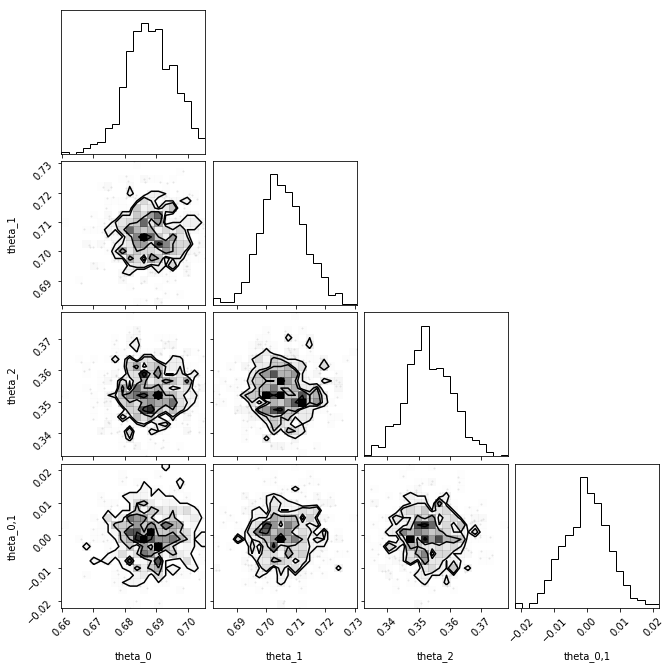

In [15]:
def dot(X, Z):
    return jnp.dot(X, Z[..., None])[..., 0]

# The kernel that corresponds to our quadratic regressor.
def kernel(X, Z, eta1, eta2, c, jitter=1.0e-4):
    eta1sq = jnp.square(eta1)
    eta2sq = jnp.square(eta2)
    k1 = 0.5 * eta2sq * jnp.square(1.0 + dot(X, Z))
    k2 = -0.5 * eta2sq * dot(jnp.square(X), jnp.square(Z))
    k3 = (eta1sq - eta2sq) * dot(X, Z)
    k4 = jnp.square(c) - 0.5 * eta2sq
    if X.shape == Z.shape:
        k4 += jitter * jnp.eye(X.shape[0])
    return k1 + k2 + k3 + k4  # eqn (23)

# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, Y, hypers):
    S, P, N = hypers["expected_sparsity"], X.shape[1], X.shape[0]
    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers["alpha3"]))
    phi = sigma * (S / jnp.sqrt(N)) / (P - S)
    eta1 = numpyro.sample("eta1", dist.HalfCauchy(phi))
    msq = numpyro.sample("msq", dist.InverseGamma(hypers["alpha1"], hypers["beta1"]))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers["alpha2"], hypers["beta2"]))
    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    lam = numpyro.sample("lambda", dist.HalfCauchy(jnp.ones(P)))
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    # compute kernel
    kX = kappa * X
    k = kernel(kX, kX, eta1, eta2, hypers["c"]) + sigma**2 * jnp.eye(N)
    assert k.shape == (N, N)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,)


# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((2, P))
    probe = probe.at[:, dimension].set(jnp.array([1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.50, -0.50])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((4, P))
    probe = probe.at[:, dim1].set(jnp.array([1.0, 1.0, -1.0, -1.0]))
    probe = probe.at[:, dim2].set(jnp.array([1.0, -1.0, 1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.25, -0.25, -0.25, 0.25])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


### produce valid posterior samples of theta for active singletons and active pair interaction terms
def sample_theta_space(X, Y, active_dims,active_dims_pair, msq, lam, eta1, xisq, c, sigma):
    P, N, M, M_pair = X.shape[1], X.shape[0], len(active_dims), len(active_dims_pair)//2
    # the total number of coefficients we return
#     num_coefficients = P + M * (M - 1) // 2
#     num_coefficients = M + M * (M - 1) // 2
    num_coefficients = M + M_pair
    probe = jnp.zeros((2 * P + 2 * M * (M - 1), P))
    vec = jnp.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = probe.at[start1 : start1 + 2, dim].set(jnp.array([1.0, -1.0]))
        vec = vec.at[start2, start1 : start1 + 2].set(jnp.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = probe.at[start1 : start1 + 4, dim1].set(
                jnp.array([1.0, 1.0, -1.0, -1.0])
            )
            probe = probe.at[start1 : start1 + 4, dim2].set(
                jnp.array([1.0, -1.0, 1.0, -1.0])
            )
            vec = vec.at[start2, start1 : start1 + 4].set(
                jnp.array([0.25, -0.25, -0.25, 0.25])
            )
            start1 += 4
            start2 += 1
    
    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))
    kX = kappa * X
    kprobe = kappa * probe
    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    L = cho_factor(k_xx, lower=True)[0]
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)
    
    mu = jnp.matmul(k_probeX, cho_solve((L, True), Y))
    mu = jnp.sum(mu * vec, axis=-1)
    Linv_k_probeX = solve_triangular(L, jnp.transpose(k_probeX), lower=True)
    covar = k_prbprb - jnp.matmul(jnp.transpose(Linv_k_probeX), Linv_k_probeX)
    covar = jnp.matmul(vec, jnp.matmul(covar, jnp.transpose(vec)))

    # sample from N(mu, covar)
    L = jnp.linalg.cholesky(covar)
    sample = mu + jnp.matmul(L, np.random.randn(num_coefficients))

    return sample


# Helper function for doing HMC inference
def run_inference(model, args, rng_key, X, Y, hypers):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, hypers)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()

# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = jnp.mean(mus)
    mean_var = jnp.mean(variances) + jnp.mean(jnp.square(mus)) - jnp.square(mean_mu)
    return mean_mu, mean_var

# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there is a single pairwise interaction
# between the first and second dimensions.
def get_data(N=20, S=2, P=10, sigma_obs=0.05):
    assert S < P and P > 1 and S > 0
    np.random.seed(0)
    X = np.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * np.random.rand(S)
    # generate data using the S coefficients and a single pairwise interaction
    Y = (
        np.sum(X[:, 0:S] * W, axis=-1)
        + X[:, 0] * X[:, 1]
        + sigma_obs * np.random.randn(N)
    )
    Y -= jnp.mean(Y)
    Y_std = jnp.std(Y)
    assert X.shape == (N, P)
    assert Y.shape == (N,)
    return X, Y / Y_std, W / Y_std, 1.0 / Y_std


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_singleton_mean_variance(
            X, Y, dimension, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_pairwise_mean_variance(
            X, Y, dim1, dim2, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


def main(args):
    X, Y, expected_thetas, expected_pairwise = get_data(
        N=args.num_data, P=args.num_dimensions, S=args.active_dimensions)

    # setup hyperparameters
    hypers = {
        "expected_sparsity": max(1.0, args.num_dimensions / 10),
        "alpha1": 3.0,
        "beta1": 1.0,
        "alpha2": 3.0,
        "beta2": 1.0,
        "alpha3": 1.0,
        "c": 1.0,}

    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
        jnp.arange(args.num_dimensions))

    print(
        "Coefficients theta_1 to theta_%d used to generate the data:"
        % args.active_dimensions,
        expected_thetas,)
    print(
        "The single quadratic coefficient theta_{1,2} used to generate the data:",
        expected_pairwise,)
    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print(
            "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
            % (dim + 1, args.num_dimensions, inactive, mean, std)
        )
    print(
        "Identified a total of %d active dimensions; expected %d."
        % (len(active_dimensions), args.active_dimensions)
    )


    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    # get the active pairs for corner plot labelling
    active_dimensions_pairs = []
    if len(active_dimensions) > 0:
        dim_pairs = jnp.array(
            list(itertools.product(active_dimensions, active_dimensions))
        )
        means, stds = vmap(
            lambda dim_pair: analyze_pair_of_dimensions(
                samples, X, Y, dim_pair[0], dim_pair[1], hypers
            )
        )(dim_pairs)
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            lower, upper = mean - 3.0 * std, mean + 3.0 * std
            if not (lower < 0.0 and upper > 0.0):
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))
                active_dimensions_pairs.append(dim1)
                active_dimensions_pairs.append(dim2)



        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # all the MCMC samples obtained from the HMC sampler.
        thetas = []
        for i in range(args.num_samples):
            thetai = sample_theta_space(
                X,
                Y,
                active_dimensions,
                active_dimensions_pairs,
                samples["msq"][i],
                samples["lambda"][i],
                samples["eta1"][i],
                samples["xisq"][i],
                hypers["c"],
                samples["sigma"][i],
            )
            thetas.append(thetai)           
        thetas = np.array(thetas)

        lbs = []
        for index in active_dimensions:
            lbs.append(f'theta_{index}')
        for idx in range(len(active_dimensions_pairs)//2):
            lbs.append(f'theta_{active_dimensions_pairs[int(idx*2)]},{active_dimensions_pairs[int(idx*2)+1]}')
        fig = corner.corner(thetas,labels=lbs)

class Args:
    num_samples = 550
    num_warmup = 500
    num_chains = 1
    num_data = 100
    num_dimensions = 20 
    active_dimensions = 3
    device ="cpu" 
    thetas = None
args = Args()
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)
main(args)

### Application (5pts)

Find an application from your area of research where the kernel-interaction method is directly applicable, or could be applied with some modification. Describe the application for a statistically knowledgeable but non-expert audience (think: your peers in SML 505). In particular, explain why the sparse interaction ansatz is justified. Then demonstrate the use with a suitable data set of your own choice. Explain what you find.

This task has three parts:

* Identify and descuss which possible effects there could be.
* Find suitable data.
* Perform the inference and interpret the results.

You will probably need to iterate and refine along the way. Explain your reasoning about the kinds of features you decided to include in your analysis. Then report the most important direct and pairwise interactions. Visualized the posterior samples with `corner`.

**Note:** This is an exploratory study. If your approach is sound, but the data don't show firm trends, points will be awarded. Make sure that you have permission to use the data and include it as separate file in your submission.

**Hint:** Don't forget to standardize the data by subtracting the mean and dividing by the standard deviation.

## Identify and discuss which possible effects there could be

Liquid-liquid phase seperation of proteins is an important mechanism underlying celluar organizations. In this project, We seek to understand the effect of protein sequence to its phase seperation propencity. 


Our input data $X$ (104 samples, 10 main effects) are the physicochemical characterizations of the protein sequences, and the response variable $y$ is the second viral coefficient $B_2$, which measures the  phase seperation propency and is obtained from atomistic simulations.

The main effects are certain properties of protein chains. The detailed meaning of the features: feature 1 is the chain length, feature 2-10 are all different physical properties such as shannon entropy, total molecular weight, fraction of positive charges residues (residue means amino acid, certain amino acids carry charges, positive or negative, in aqueous solotion while others are neutal, aka no charges), etc. Since the rest of 9 features are related to length, they are normalized by length before the entire data are normalized.

We are also interested in learning whether pairwise interaction terms of these main effects affect the phase seperation propencity pf protein chains.

## Find suitable data and exploratory data analysis

The data was obtained from Jacob's group in Department of Chemistry.

We first examine the summary statistics, then standardize the data and visualize the distribution of the features. Some parts are commented out for a cleaner notebook. They can be uncommented if desired.

In [5]:
df_raw = pd.read_csv('features_wlabel.dat',header=0,sep='\s+').iloc[::15,20:]
df_raw['MF'] = df_raw['MF']/df_raw['length']
df_raw['SCD'] = df_raw['SCD']/df_raw['length']
df_raw['SHD'] = df_raw['SHD']/df_raw['length']
df_raw['q'] = df_raw['q']/df_raw['length']
df_raw['lambda'] = df_raw['lambda']/df_raw['length']
df_raw['posres'] = df_raw['posres']/df_raw['length']
df_raw['negres'] = df_raw['negres']/df_raw['length']
df_raw['entropy'] = df_raw['entropy']/df_raw['length']
df_raw['mass'] = df_raw['mass']/df_raw['length']
y = pd.read_csv('B2_all.dat',header=None,names=['B2']).iloc[::15]
print(df_raw.shape)  #(104, 30)
# print(y.shape)  #(104, 1)

## summary statistics of the features before standardization
df_raw.describe()


,length,MF,SCD,SHD,q,lambda,posres,negres,entropy,mass
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,32.250000,7869.347460,-0.001589,0.111832,0.105735,0.559434,0.149196,0.162965,0.110856,114.442364
std,9.522329,5295.495499,0.084761,0.032076,0.102620,0.090416,0.097766,0.102805,0.029835,12.813618
min,20.000000,1899.329048,-0.203156,0.054147,0.000000,0.307000,0.000000,0.000000,0.062280,81.291682
25%,24.000000,5085.023762,-0.012666,0.088436,0.033065,0.506477,0.079231,0.094866,0.084411,108.272381
50%,31.000000,6888.156338,-0.004019,0.107000,0.084220,0.552424,0.132456,0.139444,0.107007,112.213598
75%,39.250000,8558.181362,0.010868,0.128448,0.147143,0.586684,0.200000,0.222222,0.130690,117.809764
max,50.000000,39684.751500,0.459029,0.230571,0.588235,0.901381,0.425000,0.617647,0.176100,165.022333


In [7]:
### standardize the data and visualize the distributions of features
df = (df_raw-df_raw.mean())/df_raw.std()

### uncomment the lines below for visualization of histograms of main effects
# ncols=5
# nrows=2
# fig, axs = plt.subplots(nrows,ncols,figsize=(18, 8))
# fig.subplots_adjust(hspace = .3, wspace=.3)
# for i, col in enumerate(df.columns):
#     df[col].hist(ax=axs.flat[i])
#     axs.flat[i].set_title(f'{col}')

To prepare for the subsequent SKIM-KIS analysis and the LASSO benchmark, we examine the Pearson correlation coefficient between features.  

The features are mostly moderately correlated with a few exceptions. Lambda, SHDs, length and entropy are strongly correlated. 

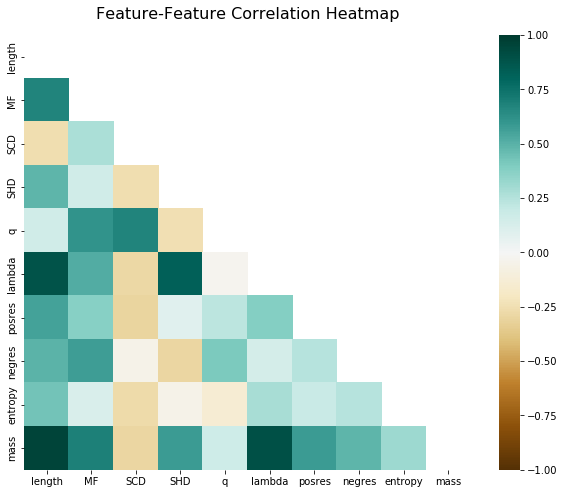

In [8]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1,cmap='BrBG')
heatmap.set_title('Feature-Feature Correlation Heatmap', fontdict={'fontsize':16}, pad=16);

We also examine the relationship between y and individual features. We see that a few of the features exhibit strong linear correlation with the response variable y (label of y is B2).

In [26]:
### visualize features vs B2 in scatter plot

# ncols=5
# nrows=2
# fig, axs = plt.subplots(nrows,ncols,figsize=(18, 8))
# fig.subplots_adjust(hspace = .3, wspace=.4)
# for i, col in enumerate(df.columns):
#     dff = pd.concat([df[col],y],axis=1)
#     dff.plot.scatter(x=col,y='B2',ax=axs.flat[i])

## Lasso benchmark
Similar to the paper, we implement a Lasso bench mark. The design matrix is all the 10 main effects and all their pairwise interaction terms. The regularization coefficient of the L1 penalty is tuned using a grid search 5-fold cross validation.

In [9]:
p = df.shape[1]
pair_idx_list = list(itertools.combinations(np.linspace(0,p-1,num=p,dtype=int), 2))
pair_names = [f'{df.columns[pair_idx_list[k][0]]}-{df.columns[pair_idx_list[k][1]]}' for k in range(len(pair_idx_list))]
pair_terms = []
for pair_idx in pair_idx_list:
    pair_terms.append(df_raw.iloc[:,pair_idx[0]]*df_raw.iloc[:,pair_idx[1]])
df_pair_terms = pd.concat(pair_terms,axis=1,keys=pair_names)
df_lasso_raw = pd.concat([df_raw,df_pair_terms],axis=1)
### standardization after appending interaction terms
df_lasso = (df_lasso_raw-df_lasso_raw.mean())/df_lasso_raw.std()
## df_lasso.shape  #(1554, 465)

parameters = {'alpha':[1e-2,1e-1,1,10,100,1000]}
lasso = linear_model.Lasso()
clf = GridSearchCV(lasso, parameters,return_train_score=True)
clf.fit(df_lasso, y)
res_lasso = clf.best_estimator_.coef_

In [10]:
print(f'proportion of coefficients selected by Lasso is :{sum(res_lasso>0.0)/len(res_lasso)}')
print(f'number of non-zero coefficients is : {sum(res_lasso>0.0)}')
print(f'features selected by Lasso are : {df_lasso.columns[res_lasso>0.0]}')

proportion of coefficients selected by Lasso is :0.18181818181818182
number of non-zero coefficients is : 10
features selected by Lasso are : Index(['length', 'entropy', 'length-entropy', 'SCD-SHD', 'SCD-lambda',
       'SCD-negres', 'SHD-posres', 'q-lambda', 'q-posres', 'q-entropy'],
      dtype='object')


## Inference and results

sample: 100%|██████████| 1500/1500 [00:16<00:00, 90.66it/s, 15 steps of size 1.76e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      eta1      0.21      0.12      0.18      0.05      0.35    386.71      1.00
 lambda[0]      5.15     14.37      1.93      0.08      9.16    543.77      1.00
 lambda[1]      5.55     22.11      1.92      0.02      8.66    549.01      1.00
 lambda[2]     16.27    129.98      3.21      0.48     14.76    330.77      1.00
 lambda[3]      0.72      1.07      0.47      0.00      1.45    805.71      1.00
 lambda[4]      1.93      3.51      1.34      0.29      3.42    550.68      1.00
 lambda[5]      7.94     81.01      2.32      0.27      8.38    895.57      1.00
 lambda[6]      1.27      4.56      0.43      0.00      2.04    465.59      1.00
 lambda[7]      7.22     50.33      1.56      0.01      8.88    720.36      1.00
 lambda[8]      0.34      0.34      0.25      0.00      0.74    758.19      1.00
 lambda[9]      2.15     15.65      1.11      0.04      3.29    899.19      1.00
       msq      0.34      0

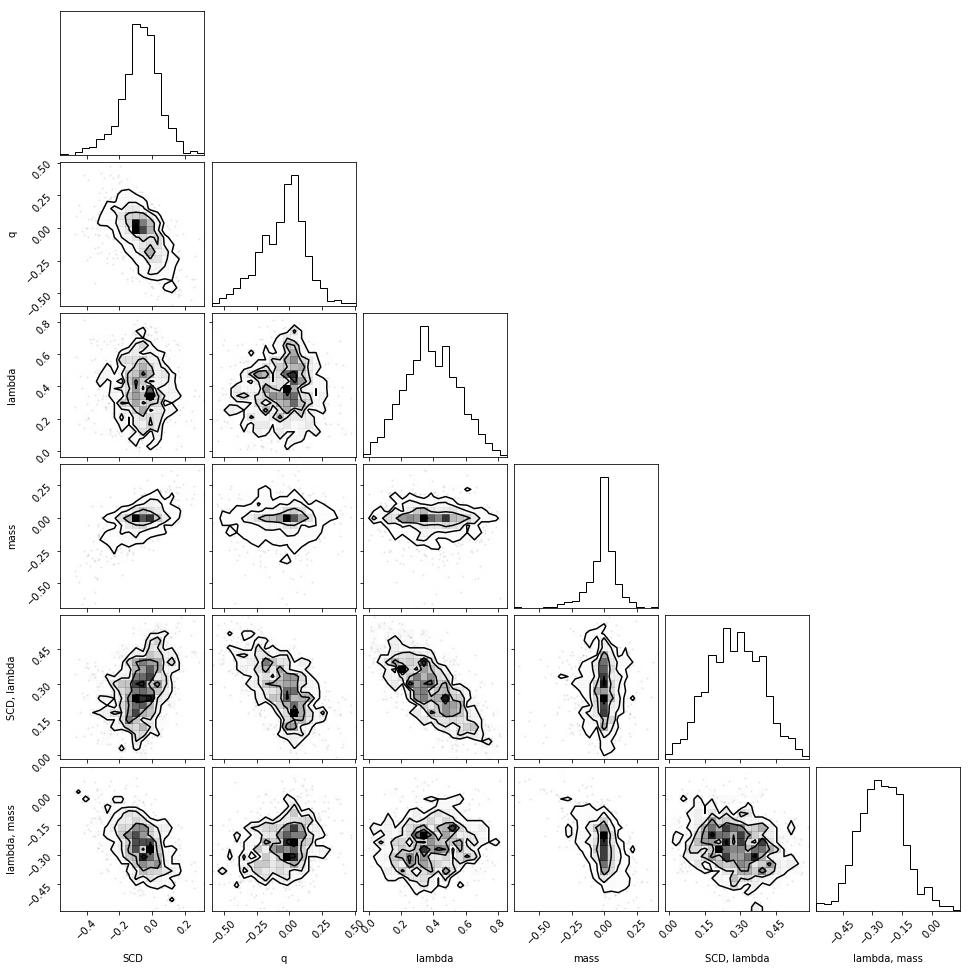

In [14]:
def dot(X, Z):
    return jnp.dot(X, Z[..., None])[..., 0]

# The kernel that corresponds to our quadratic regressor.
def kernel(X, Z, eta1, eta2, c, jitter=1.0e-4):
    eta1sq = jnp.square(eta1)
    eta2sq = jnp.square(eta2)
    k1 = 0.5 * eta2sq * jnp.square(1.0 + dot(X, Z))
    k2 = -0.5 * eta2sq * dot(jnp.square(X), jnp.square(Z))
    k3 = (eta1sq - eta2sq) * dot(X, Z)
    k4 = jnp.square(c) - 0.5 * eta2sq
    if X.shape == Z.shape:
        k4 += jitter * jnp.eye(X.shape[0])
    return k1 + k2 + k3 + k4  # eqn (23)

# Most of the model code is concerned with constructing the sparsity inducing prior.
def model(X, Y, hypers):
    S, P, N = hypers["expected_sparsity"], X.shape[1], X.shape[0]
    sigma = numpyro.sample("sigma", dist.HalfNormal(hypers["alpha3"]))
    phi = sigma * (S / jnp.sqrt(N)) / (P - S)
    eta1 = numpyro.sample("eta1", dist.HalfCauchy(phi))
    msq = numpyro.sample("msq", dist.InverseGamma(hypers["alpha1"], hypers["beta1"]))
    xisq = numpyro.sample("xisq", dist.InverseGamma(hypers["alpha2"], hypers["beta2"]))
    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    lam = numpyro.sample("lambda", dist.HalfCauchy(jnp.ones(P)))
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    # compute kernel
    kX = kappa * X
    k = kernel(kX, kX, eta1, eta2, hypers["c"]) + sigma**2 * jnp.eye(N)
    assert k.shape == (N, N)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,)


# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((2, P))
    probe = probe.at[:, dimension].set(jnp.array([1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.50, -0.50])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, msq, lam, eta1, xisq, c, sigma):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((4, P))
    probe = probe.at[:, dim1].set(jnp.array([1.0, 1.0, -1.0, -1.0]))
    probe = probe.at[:, dim2].set(jnp.array([1.0, -1.0, 1.0, -1.0]))

    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))

    kX = kappa * X
    kprobe = kappa * probe

    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)

    vec = jnp.array([0.25, -0.25, -0.25, 0.25])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


### produce valid posterior samples of theta for active singletons and active pair interaction terms
def sample_theta_space(X, Y, active_dims, active_dims_pair, msq, lam, eta1, xisq, c, sigma):
    P, N, M, M_pair = X.shape[1], X.shape[0], len(active_dims), len(active_dims_pair)//2
    num_coefficients = M + M_pair
    probe = jnp.zeros((2 * P + 2 * M * (M - 1), P))
    vec = jnp.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = probe.at[start1 : start1 + 2, dim].set(jnp.array([1.0, -1.0]))
        vec = vec.at[start2, start1 : start1 + 2].set(jnp.array([0.5, -0.5]))
        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = probe.at[start1 : start1 + 4, dim1].set(
                jnp.array([1.0, 1.0, -1.0, -1.0])
            )
            probe = probe.at[start1 : start1 + 4, dim2].set(
                jnp.array([1.0, -1.0, 1.0, -1.0])
            )
            vec = vec.at[start2, start1 : start1 + 4].set(
                jnp.array([0.25, -0.25, -0.25, 0.25])
            )
            start1 += 4
            start2 += 1
    
    eta2 = jnp.square(eta1) * jnp.sqrt(xisq) / msq
    kappa = jnp.sqrt(msq) * lam / jnp.sqrt(msq + jnp.square(eta1 * lam))
    kX = kappa * X
    kprobe = kappa * probe
    k_xx = kernel(kX, kX, eta1, eta2, c) + sigma**2 * jnp.eye(N)
    L = cho_factor(k_xx, lower=True)[0]
    k_probeX = kernel(kprobe, kX, eta1, eta2, c)
    k_prbprb = kernel(kprobe, kprobe, eta1, eta2, c)
    
    mu = jnp.matmul(k_probeX, cho_solve((L, True), Y))
    mu = jnp.sum(mu * vec, axis=-1)
    Linv_k_probeX = solve_triangular(L, jnp.transpose(k_probeX), lower=True)
    covar = k_prbprb - jnp.matmul(jnp.transpose(Linv_k_probeX), Linv_k_probeX)
    covar = jnp.matmul(vec, jnp.matmul(covar, jnp.transpose(vec)))

    # sample from N(mu, covar)
    L = jnp.linalg.cholesky(covar)
    sample = mu + jnp.matmul(L, np.random.randn(num_coefficients))

    return sample


# Helper function for doing HMC inference
def run_inference(model, args, rng_key, X, Y, hypers):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, hypers)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()

# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = jnp.mean(mus)
    mean_var = jnp.mean(variances) + jnp.mean(jnp.square(mus)) - jnp.square(mean_mu)
    return mean_mu, mean_var

# Create artificial regression dataset where only S out of P feature
# dimensions contain signal and where there is a single pairwise interaction
# between the first and second dimensions.
def get_data(N=20, S=2, P=10, sigma_obs=0.05):
    assert S < P and P > 1 and S > 0
    np.random.seed(0)
    X = np.random.randn(N, P)
    # generate S coefficients with non-negligible magnitude
    W = 0.5 + 2.5 * np.random.rand(S)
    # generate data using the S coefficients and a single pairwise interaction
    Y = (
        np.sum(X[:, 0:S] * W, axis=-1)
        + X[:, 0] * X[:, 1]
        + sigma_obs * np.random.randn(N)
    )
    Y -= jnp.mean(Y)
    Y_std = jnp.std(Y)
    assert X.shape == (N, P)
    assert Y.shape == (N,)
    return X, Y / Y_std, W / Y_std, 1.0 / Y_std

def load_data(data_x, data_y ):
    X = data_x
    Y = data_y
    Y_std = jnp.std(Y)
    return X, Y / Y_std
    

# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_singleton_mean_variance(
            X, Y, dimension, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, hypers):
    vmap_args = (
        samples["msq"],
        samples["lambda"],
        samples["eta1"],
        samples["xisq"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda msq, lam, eta1, xisq, sigma: compute_pairwise_mean_variance(
            X, Y, dim1, dim2, msq, lam, eta1, xisq, hypers["c"], sigma
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


def main(args, data_x, data_y, x_label, y_label):
    X, Y = load_data(data_x, data_y)
    # setup hyperparameters
    hypers = {
        "expected_sparsity": max(1.0, args.num_dimensions / 10),
        "alpha1": 3.0,
        "beta1": 1.0,
        "alpha2": 3.0,
        "beta2": 1.0,
        "alpha3": 1.0, 
        "c": 1.0,}
    # do inference
    rng_key = random.PRNGKey(0)
    samples = run_inference(model, args, rng_key, X, Y, hypers)

    # compute the mean and square root variance of each coefficient theta_i
    means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y, dim, hypers))(
        jnp.arange(args.num_dimensions))

    active_dimensions = []

    for dim, (mean, std) in enumerate(zip(means, stds)):
        # we mark the dimension as inactive if the interval [mean - 1.95 * std, mean + 1.95 * std] contains zero
        lower, upper = mean - 1.95 * std, mean + 1.95 * std

        inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
        if inactive == "active":
            active_dimensions.append(dim)
        print(
            "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
            % (dim + 1, args.num_dimensions, inactive, mean, std)
        )
        print(
        "Identified a total of %d active dimensions; expected %d."
        % (len(active_dimensions), args.active_dimensions)
        )


    # Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
    # Note that the resulting numbers are only meaningful for i != j.
    # get the active pairs for corner plot labelling
    active_dimensions_pairs = []
    if len(active_dimensions) > 0:
        dim_pairs = jnp.array(
            list(itertools.product(active_dimensions, active_dimensions))
        )
        means, stds = vmap(
            lambda dim_pair: analyze_pair_of_dimensions(
                samples, X, Y, dim_pair[0], dim_pair[1], hypers
            )
        )(dim_pairs)
        for dim_pair, mean, std in zip(dim_pairs, means, stds):
            dim1, dim2 = dim_pair
            if dim1 >= dim2:
                continue
            lower, upper = mean - 1.5 * std, mean + 1.5 * std
            if not (lower < 0.0 and upper > 0.0):
                format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
                print(format_str % (dim1 + 1, dim2 + 1, mean, std))
                active_dimensions_pairs.append(dim1)
                active_dimensions_pairs.append(dim2)
        # Draw a single sample of coefficients theta from the posterior, where we return all singleton
        # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
        # all the MCMC samples obtained from the HMC sampler.
        thetas = []
        for i in range(args.num_samples):
            thetai = sample_theta_space(
                X,
                Y,
                active_dimensions,
                active_dimensions_pairs,
                samples["msq"][i],
                samples["lambda"][i],
                samples["eta1"][i],
                samples["xisq"][i],
                hypers["c"],
                samples["sigma"][i],
            )
            thetas.append(thetai)           
        thetas = np.array(thetas)

        lbs = []
        for index in active_dimensions:
            lbs.append('%s' %x_label[index])
        for idx in range(len(active_dimensions_pairs)//2):
            lbs.append('%s, %s' %(x_label[active_dimensions_pairs[2*idx]], x_label[active_dimensions_pairs[2*idx+1]]))
 
        fig = corner.corner(thetas,labels=lbs)

class Args:
    num_samples = 1000
    num_warmup = 500
    num_chains = 1
    num_data = 104
    num_dimensions = 10
    active_dimensions = 4
    device ="cpu" 
    thetas = None
    
    
args = Args()
numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)

df_raw = pd.read_csv('features_wlabel.dat',header=0,sep='\s+').iloc[::15, 20:]
df_raw['MF'] = df_raw['MF']/df_raw['length']
df_raw['SCD'] = df_raw['SCD']/df_raw['length']
df_raw['SHD'] = df_raw['SHD']/df_raw['length']
df_raw['q'] = df_raw['q']/df_raw['length']
df_raw['lambda'] = df_raw['lambda']/df_raw['length']
df_raw['posres'] = df_raw['posres']/df_raw['length']
df_raw['negres'] = df_raw['negres']/df_raw['length']
df_raw['entropy'] = df_raw['entropy']/df_raw['length']
df_raw['mass'] = df_raw['mass']/df_raw['length']


df = (df_raw-df_raw.mean())/df_raw.std()
data = np.array(df)


y_raw = np.loadtxt('B2_all.dat')[::15]
y = (y_raw-np.mean(y_raw))/np.std(y_raw)

xlabel = df.columns
ylabel = ['B2']
main(args, data, y, xlabel, ylabel)

## Result interpretation

For parameter tuning and refinement, we found that using a z = 2.59 (99.5th percentile of standard normal distribution) for confidence intervals of variable selection is too stringent. Since our data are noisier than the example included with the code, we use instead z = 1.95 and 1.5 for selection of main effcts and interaction terms.

From the inference, the active singletons are sequence charge decoration(SCD), net charge(q), hydrophobicity ($\lambda$) and molecular weight (mass), which makes sense physically since they capture the charge-charge interactions between molecules and the solvent interactions between molecules and water. 

The pairwise interactions the we identified are also very reasonable. The dominant pair interaction SCD-$\lambda$ shows charge interaction and hydrophobic interactions are cooperative. $\lambda$-molecular weight has minor effect, probbably due to the fact that hydrophobic amino acids usuallt are heavier. The pairwise interactions are no significant comparing to the dominant singleton, which probably suggests out model is sufficiently linear.

Comparing to the Lasso benchmark, the results from SKIM-KIS makes more sense because although Lasso gives a sparse solution, length-entropy is selected as one of the pairwise interactions. But since the rest of the 9 features are already normalized by length before being put into models, none of the interaction terms should contain length as a main effect.

In [20]:
!jupyter nbconvert --to pdf FinalProject_FCCD.ipynb --template classic

[NbConvertApp] Converting notebook FinalProject_FCCD.ipynb to pdf
[NbConvertApp] Support files will be in FinalProject_FCCD_files/
[NbConvertApp] Making directory ./FinalProject_FCCD_files
[NbConvertApp] Making directory ./FinalProject_FCCD_files
[NbConvertApp] Making directory ./FinalProject_FCCD_files
[NbConvertApp] Writing 142299 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 402224 bytes to FinalProject_FCCD.pdf
